In [ ]:
# export PATH=/home/jnb5885/.conda/envs/take2/bin:$PATH

In [2]:
import transformer_lens
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

/home/jnb5885/miniconda3/envs/ling/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [4]:
# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

# Run the model and get logits and activations
logits, activations = model.run_with_cache("Hello World")

Loaded pretrained model gpt2-small into HookedTransformer


## tokens

In [4]:
N_WORDS = 10000
with open('common_words.txt', 'r') as file:
    words = np.random.choice([l.rstrip("\n") for l in file.readlines()], N_WORDS)

words

array(['valley', 'syracuse', 'wave', ..., 'queens', 'parameter', 'ohio'],
      dtype='<U22')

In [5]:
word_len_dict = {}
rows = []
for w in words:
    t = len(model.to_tokens(w, prepend_bos=False).squeeze(0))
    t_space = len(model.to_tokens(f" {w}", prepend_bos=False).squeeze(0))
    word_len_dict[w] = t_space
    row = {
        "word": w,
        "n_tokens": t,
        "n_tokens_space": t_space
    }
    rows.append(row)

word_df = pd.DataFrame(rows)
word_df

,word,n_tokens,n_tokens_space
0,valley,2,1
1,syracuse,2,2
2,wave,1,1
3,scholarship,3,1
4,rebates,2,2
...,...,...,...
9995,rail,1,1
9996,listed,1,1
9997,queens,2,1
9998,parameter,2,1


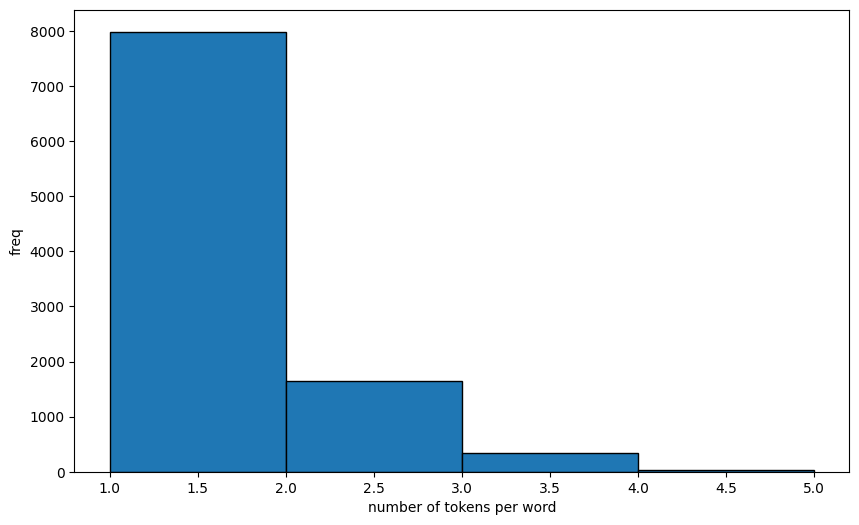

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(word_df['n_tokens_space'], bins=len(word_df['n_tokens_space'].unique())-1, edgecolor='k')
plt.xlabel('number of tokens per word')
plt.ylabel('freq')
plt.show()

## building dataset

In [17]:
word_len = np.vectorize(lambda x: word_len_dict[x])

In [11]:
PREFIX = "Hello and welcome to my blog, where I love word.\nWhat "
BATCH_SIZE = 256
N_SAMPLE = 10

prefix_len = len(model.to_tokens(PREFIX, prepend_bos=True).squeeze(0)) - 1

def generate_batch():
    batch_words = []
    for i in range(BATCH_SIZE):
        sampled = np.random.choice(words, N_SAMPLE)

        batch_words.append(sampled)

    tokens = model.to_tokens([PREFIX + " ".join(s) for s in batch_words], prepend_bos=True)
    mapped_len = word_len(batch_words)

    word_idxs = np.ones((BATCH_SIZE, N_SAMPLE * 3)) * -1
    for i, r in enumerate(mapped_len):
        row = np.repeat(np.arange(N_SAMPLE), r)
        word_idxs[i, :len(row)] = row

    return tokens, word_idxs

In [19]:
DATA_BATCHES = 20

torch.set_grad_enabled(False)

all_resids = []
all_word_idxs = []

for i_batch in tqdm(range(DATA_BATCHES)):
    tokens, word_idxs = generate_batch()
    _, cache = model.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    # print(residuals.shape) # num_layers, batch_size, seq_length, hidden_dim?

    residuals = residuals[:, :, prefix_len:, :]
    word_idxs = word_idxs[:, :residuals.size(dim=2)]

    # print(residuals.shape)
    # print(word_idxs.shape)

    mask = word_idxs != -1

    all_resids.append(residuals.cpu().numpy()[:, mask].reshape(12, -1, model.cfg.d_model))
    all_word_idxs.append(word_idxs[mask])


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


In [20]:
x_all_layers = np.concatenate(all_resids, axis=1)
y = np.concatenate(all_word_idxs)

print(x_all_layers.shape)
print(y.shape)

(12, 63820, 768)
(63820,)


In [21]:
np.save("63k_X_alllayers.npy", x_all_layers)

In [22]:
np.save("63k_Y.npy", y)

In [5]:
x_all_layers = np.load("63k_X_alllayers.npy")
y = np.load("63k_Y.npy")

## training probe

In [6]:
LAYER = 3

In [24]:
# picking some subset of data to train on

train_idxs = np.random.choice(len(y), 2000)
sub_X = x_all_layers[LAYER, train_idxs, :]
sub_Y = y[train_idxs]

print(sub_X.shape)
print(sub_Y.shape)

(2000, 768)
(2000,)


In [7]:
# train on all data
sub_X = x_all_layers[LAYER, :, :]
sub_Y = y

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sub_X, sub_Y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
lr_model = LogisticRegression(multi_class='ovr', solver='saga', random_state=42, max_iter=100, C=1.0)

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Print a classification report
y_pred = lr_model.predict(X_train)
print(classification_report(y_train, y_pred))
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

/home/jnb5885/miniconda3/envs/ling/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5084
         1.0       0.93      0.92      0.92      5079
         2.0       0.76      0.77      0.76      5128
         3.0       0.61      0.61      0.61      5139
         4.0       0.53      0.52      0.52      5060
         5.0       0.48      0.48      0.48      5085
         6.0       0.47      0.50      0.48      5183
         7.0       0.51      0.47      0.49      5109
         8.0       0.57      0.49      0.53      5104
         9.0       0.75      0.87      0.81      5085

    accuracy                           0.66     51056
   macro avg       0.66      0.66      0.66     51056
weighted avg       0.66      0.66      0.66     51056

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1259
         1.0       0.90      0.88      0.89      1271
         2.0       0.69      0.69      0.69      1317
         3.0       0.51 

### saving probe

In [9]:
import joblib

# Save the model to a file
joblib.dump(lr_model, f'probe_layer{LAYER}.pkl')

['probe_layer3.pkl']

## testing probe on specific examples

In [12]:
s_example = "This has two sentences. What will the probes find? Who knows it could be anything"
t_example = model.to_tokens(PREFIX + s_example, prepend_bos=True)

print(s_example)
print(t_example)

_, cache = model.run_with_cache(t_example, names_filter=lambda x: x.endswith("resid_post"))
residuals = cache.stack_activation("resid_post")
residuals = residuals[:, :, prefix_len:, :]
residuals.shape

This has two sentences. What will the probes find? Who knows it could be anything
tensor([[50256, 15496,   290,  7062,   284,   616,  4130,    11,   810,   314,
          1842,  1573,    13,   198,  2061,   770,   468,   734, 13439,    13,
          1867,   481,   262, 33124,  1064,    30,  5338,  4206,   340,   714,
           307,  1997]], device='cuda:0')


torch.Size([12, 1, 17, 768])

In [13]:
x_example = residuals.squeeze(1).cpu().numpy()
x_example.shape

(12, 17, 768)

In [14]:
pred_example = lr_model.predict(x_example[LAYER, :, :])
pred_example

array([0., 0., 2., 2., 4., 8., 0., 1., 1., 2., 8., 8., 9., 9., 9., 9., 9.])